<a href="https://colab.research.google.com/github/rafaeljosem/MNA-ProyectoIntegrador_EQ10/blob/main/proyecto_integrador_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

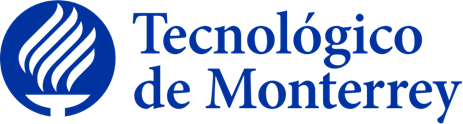

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

### Domingo 5 de mayo de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

# **Exploratory Data Analysis**
### CAPSTONE PROJECT - MNA

**0. Description**

In this notebook we will be processing eleven (11) laws of the 300+ included in the dataset in order to facilitate the analysis. We will focus on mexican environmental laws for this EDA, although our model will be trained on many others too.

**1. Libraries and Helper Functions**

First we import the libraries we'll be using

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spacy
import numpy as np
import requests

In [2]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 22.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Also, we define some helper functions that we'll use for this project

In [3]:

#The corpus is encoded as latin1, so we must decode it first
def decode_text(text: str) -> str:
    try:
        return text.encode("latin_1").decode("utf-8")
    except UnicodeDecodeError:
        return text.encode("latin_1").decode("utf-8", errors="replace")

#This method removes newlines so it's easier to analyse the corpus
def remove_new_lines(lines: list) -> list:
    clean_text = []
    for line in lines:
        if not isinstance(line, str):
            continue
        line = line.strip(' ')
        if line == '':
            continue

        #clean_text.append(decode_text(line))

        try:
          clean_text.append(line)
        except UnicodeDecodeError:
          clean_text.append(decode_text(line))

    return clean_text

#This method reads the files and execute the methods above
def read_without_new_lines(file_name:str):
    #with open(file_name, encoding='latin_1') as f:
    try:
      with open(file_name) as f:
          text = f.read().splitlines()
          clean_text = remove_new_lines(text)
          if len(text) != 0:
              title = clean_text[0]
          return (title, " ".join(clean_text))
    except UnicodeDecodeError:
      with open(file_name, encoding='latin_1') as f:
          text = f.read().splitlines()
          clean_text = remove_new_lines(text)
          if len(text) != 0:
              title = clean_text[0]
          return (title, " ".join(clean_text))

The next methods will help us interpreting the corpus by tokenizing, extracting POS and named entitities

In [4]:
nlp = spacy.load('es_core_news_sm')

# Converts the text to a spacy corpus
def preprocess(text: str):
    text = nlp(text)
    return text

#Extracts the token
def get_tokens(doc: str) -> list:
    return [token.text for token in doc]

# Extracts POS
def get_pos(doc: str) -> list:
    return [token.pos_ for token in doc]

def get_pos_tags(doc):
    store ={}
    pos_count = doc.count_by(spacy.attrs.POS)
    for tag,count in sorted(pos_count.items()):
        store[doc.vocab[tag].text] = count

    return store

def extract_entities(doc):
    return [ent.label_ for ent in doc.ents]

Finally, a helper function to download the files from github and store them in a tmp folder

In [5]:
urls = [
    ('constitucion.txt', 'https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/constitucion.txt'),
   ('ley_aguas.txt', 'https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_aguas.txt'),
   ('ley_cambio_climatico.txt', 'https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_cambio_climatico.txt'),
    ('ley_desarrollo_forestal.txt','https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_desarrollo_forestal.txt'),
    ('ley_desarrollo_sustentable.txt','https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_desarrollo_sustentable.txt'),
    ('ley_gestion_residuos.txt','https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_gestion_residuos.txt'),
    ('ley_mar.txt','https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_mar.txt'),
    ('ley_pesca.txt','https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_pesca.txt'),
    ('ley_responsabilidad_ambiental.txt','https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_responsabilidad_ambiental.txt'),
    ('ley_vertimiento_zonas_marinas.txt','https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_vertimiento_zonas_marinas.txt'),
    ('ley_vida_silvestre.txt','https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/env_data/ley_vida_silvestre.txt')
    ]

#Directory where the files are located
directory = 'tmp'

def download_files():
    if not os.path.exists(directory):
        os.mkdir(directory)
    for url in urls:
        response = requests.get(url[1])
        with open(f'{directory}/{url[0]}', mode="wb") as file:
            file.write(response.content)


**2. Loading the files**

Now let's start by first loading the files located in the directory

In [6]:
download_files()

In [7]:
corpus = []

# Let's get the content from every file in the directory
for path, folders, files in os.walk(directory):
    for file in files:
        if file.endswith('.txt'):

            title ,text =  read_without_new_lines(os.path.join(path, file))

            corpus.append({
                'Title': title,
                'Filename': file,
                'Text': text
            })


#We put them in a dataframe
df_original = pd.DataFrame.from_dict(corpus)
# Let's make a copy and leave the other as backup
df = df_original.copy()

df.head(5)

,Title,Filename,Text
0,Ley de Vertimientos en las Zonas Marinas Mexic...,ley_vertimiento_zonas_marinas.txt,Ley de Vertimientos en las Zonas Marinas Mexic...
1,Ley Federal del Mar,ley_mar.txt,Ley Federal del Mar LEY FEDERAL DEL MAR TEXTO ...
2,Ley General para la Prevención y Gestión Integ...,ley_gestion_residuos.txt,Ley General para la Prevención y Gestión Integ...
3,Constitución Política de los Estados Unidos Me...,constitucion.txt,Constitución Política de los Estados Unidos Me...
4,Ley General de Cambio Climático,ley_cambio_climatico.txt,Ley General de Cambio Climático LEY GENERAL DE...


**3. Extracting the information**

**3.1. Getting tokens and POS Tags**

Let's start extracting some data from the corpus

In [8]:
df['Document'] = df['Text'].apply(preprocess)
df['Tokens'] = df['Document'].apply(get_tokens)
df['POS'] = df['Document'].apply(get_pos)

df.head(5)



,Title,Filename,Text,Document,Tokens,POS
0,Ley de Vertimientos en las Zonas Marinas Mexic...,ley_vertimiento_zonas_marinas.txt,Ley de Vertimientos en las Zonas Marinas Mexic...,"(Ley, de, Vertimientos, en, las, Zonas, Marina...","[Ley, de, Vertimientos, en, las, Zonas, Marina...","[PROPN, ADP, PROPN, ADP, DET, PROPN, PROPN, PR..."
1,Ley Federal del Mar,ley_mar.txt,Ley Federal del Mar LEY FEDERAL DEL MAR TEXTO ...,"(Ley, Federal, del, Mar, LEY, FEDERAL, DEL, MA...","[Ley, Federal, del, Mar, LEY, FEDERAL, DEL, MA...","[PROPN, PROPN, ADP, PROPN, PROPN, PROPN, ADP, ..."
2,Ley General para la Prevención y Gestión Integ...,ley_gestion_residuos.txt,Ley General para la Prevención y Gestión Integ...,"(Ley, General, para, la, Prevención, y, Gestió...","[Ley, General, para, la, Prevención, y, Gestió...","[PROPN, PROPN, ADP, DET, PROPN, CCONJ, PROPN, ..."
3,Constitución Política de los Estados Unidos Me...,constitucion.txt,Constitución Política de los Estados Unidos Me...,"(Constitución, Política, de, los, Estados, Uni...","[Constitución, Política, de, los, Estados, Uni...","[PROPN, PROPN, ADP, DET, PROPN, PROPN, PROPN, ..."
4,Ley General de Cambio Climático,ley_cambio_climatico.txt,Ley General de Cambio Climático LEY GENERAL DE...,"(Ley, General, de, Cambio, Climático, LEY, GEN...","[Ley, General, de, Cambio, Climático, LEY, GEN...","[PROPN, PROPN, ADP, PROPN, PROPN, PROPN, PROPN..."


In [9]:
#Let's make a DF with the title and document columns only
df_analysis = df[['Title', 'Document']]

Now, we count every POS tag and store it in a column

In [10]:
df_analysis.loc[:,['Count']] = df_analysis['Document'].apply(get_pos_tags)
df_analysis['Count'].head(5)

0    {'ADJ': 764, 'ADP': 1494, 'ADV': 142, 'AUX': 1...
1    {'ADJ': 476, 'ADP': 822, 'ADV': 73, 'AUX': 41,...
2    {'ADJ': 2155, 'ADP': 4059, 'ADV': 264, 'AUX': ...
3    {'ADJ': 11442, 'ADP': 24472, 'ADV': 2226, 'AUX...
4    {'ADJ': 2187, 'ADP': 4143, 'ADV': 218, 'AUX': ...
Name: Count, dtype: object

Also, let's extract the entities in the corpus

We create a dataframe containing only the counts of every tag for every file we are analyzing

In [11]:
count_list = df_analysis['Count'].to_list()
pos_count_df =  pd.DataFrame(count_list)

pos_count_df.head(5)

,ADJ,ADP,ADV,AUX,CCONJ,DET,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,INTJ,SPACE,PART
0,764,1494,142,151,427,1310,2053,79,478,745,1060,141,3.0,728,NaN,NaN,NaN
1,476,822,73,41,209,726,797,111,133,838,431,47,1.0,211,NaN,NaN,NaN
2,2155,4059,264,331,1235,3233,4938,282,1007,2425,2466,276,3.0,1533,1.0,3.0,NaN
3,11442,24472,2226,2135,5347,20138,26022,4120,4979,17757,14577,1533,21.0,8225,3.0,670.0,2.0
4,2187,4143,218,185,1395,3078,5444,459,567,3063,2880,159,5.0,1286,1.0,31.0,NaN


To make it more readable, lets extract the labels of every POS tag

In [12]:
columns = pos_count_df.columns.to_list()
column_names = [spacy.explain(tag).title() for tag in columns]
pos_count_df.columns = column_names
pos_count_df.head(5)

,Adjective,Adposition,Adverb,Auxiliary,Coordinating Conjunction,Determiner,Noun,Numeral,Pronoun,Proper Noun,Punctuation,Subordinating Conjunction,Symbol,Verb,Interjection,Space,Particle
0,764,1494,142,151,427,1310,2053,79,478,745,1060,141,3.0,728,NaN,NaN,NaN
1,476,822,73,41,209,726,797,111,133,838,431,47,1.0,211,NaN,NaN,NaN
2,2155,4059,264,331,1235,3233,4938,282,1007,2425,2466,276,3.0,1533,1.0,3.0,NaN
3,11442,24472,2226,2135,5347,20138,26022,4120,4979,17757,14577,1533,21.0,8225,3.0,670.0,2.0
4,2187,4143,218,185,1395,3078,5444,459,567,3063,2880,159,5.0,1286,1.0,31.0,NaN


Let's rearrange the columns order to improve readability

In [13]:
pos_count_df['Title'] = df_analysis['Title']
# We want the title to be the first column
pos_count_df = pos_count_df[['Title'] + column_names ]
pos_count_df.head(5)

,Title,Adjective,Adposition,Adverb,Auxiliary,Coordinating Conjunction,Determiner,Noun,Numeral,Pronoun,Proper Noun,Punctuation,Subordinating Conjunction,Symbol,Verb,Interjection,Space,Particle
0,Ley de Vertimientos en las Zonas Marinas Mexic...,764,1494,142,151,427,1310,2053,79,478,745,1060,141,3.0,728,NaN,NaN,NaN
1,Ley Federal del Mar,476,822,73,41,209,726,797,111,133,838,431,47,1.0,211,NaN,NaN,NaN
2,Ley General para la Prevención y Gestión Integ...,2155,4059,264,331,1235,3233,4938,282,1007,2425,2466,276,3.0,1533,1.0,3.0,NaN
3,Constitución Política de los Estados Unidos Me...,11442,24472,2226,2135,5347,20138,26022,4120,4979,17757,14577,1533,21.0,8225,3.0,670.0,2.0
4,Ley General de Cambio Climático,2187,4143,218,185,1395,3078,5444,459,567,3063,2880,159,5.0,1286,1.0,31.0,NaN


**3.2. Extracting Named Entities**

Let's extract the named entities from the corpus. Below the description of every entity:

| Entity | Description                                                                     |
|--------|---------------------------------------------------------------------------------|
| PER    | People, including fictional                                                     |
| ORG    | Companies, agencies, institutions, etc.                                         |
| LOC    | Non-GPE locations, mountain ranges, bodies of water                             |
| MISC   | Miscellaneous entities, e.g., events, nationalities, products, or works of art. |



In [14]:
df_analysis.loc[:,['Entities']] = df_analysis['Document'].apply(extract_entities)
df_analysis['Entities'].head(5)

0    [MISC, LOC, LOC, MISC, LOC, MISC, MISC, LOC, L...
1    [LOC, LOC, LOC, MISC, MISC, LOC, LOC, LOC, MIS...
2    [ORG, PER, MISC, MISC, MISC, ORG, ORG, ORG, LO...
3    [PER, MISC, LOC, ORG, MISC, MISC, ORG, PER, MI...
4    [PER, ORG, LOC, MISC, ORG, ORG, PER, LOC, LOC,...
Name: Entities, dtype: object

Now we create a dataframe with each entity and its ocurrence

In [15]:
ner_count_df = pd.DataFrame()
ner_count_df['Title'] = df_analysis['Title']
#Entities are in a list, so we join them so it's easier to count
ner_count_df['Entities'] = df_analysis['Entities'].apply(lambda x: ' '.join(x))
# We create a list of unique entities to count their ocurrences
ents = np.unique(df_analysis['Entities'].to_list()[0])

for ent in ents:
    ner_count_df[f'{ent}_Count'] = ner_count_df['Entities'].str.count(ent)

ner_count_df.drop(columns='Entities',inplace=True)
ner_count_df

,Title,LOC_Count,MISC_Count,ORG_Count,PER_Count
0,Ley de Vertimientos en las Zonas Marinas Mexic...,106,226,34,115
1,Ley Federal del Mar,192,132,55,56
2,Ley General para la Prevención y Gestión Integ...,344,590,135,275
3,Constitución Política de los Estados Unidos Me...,3580,3376,1176,1929
4,Ley General de Cambio Climático,639,651,249,280
5,Ley Federal de Responsabilidad Ambiental,119,260,63,69
6,Ley General de Vida Silvestre,511,763,227,381
7,LEY DE AGUAS NACIONALES,1098,1271,552,485
8,Ley de Desarrollo Rural Sustentable,619,632,229,302
9,Ley General de Desarrollo Forestal Sustentable,720,836,214,284


Term Frequency Determination from All Documents

In [16]:
import nltk
from nltk.corpus import stopwords
import re

In [17]:
nltk.download('stopwords')    # para tener acceso a "stopwords" en varios idiomas.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
#Assign NLTK to mystopwords
mystopwords = stopwords.words('spanish')

Function that tokenizes, removes stopwords and other not wanted tokens

In [19]:
def clean_tok(doc):
  #Empty list for tokens
  tokens = []

  #SSubtitute all words that are not an alphabetic characters including accents with a blank space
  words = re.sub(r'[^a-zA-ZáéíóúüñÁÉÍÓÚÜÑ]', ' ', doc)

  #Split and lowercase all words
  words = words.lower().split()

  #Assign a copy of the words list
  tokens = words.copy()

  #Loop to remove undesired wordCiclo para revisar todas las palabras del comentario
  for word in words:

    #Si la palabra actual es una stopword o si su longitud es menor a dos, se elimina de la lista de tokens.
    if word in mystopwords or len(word) < 2:

      tokens.remove(word)

  return tokens

In [20]:
# Tokenization and cleaning process
df['Clean Tokens'] = [clean_tok(x) for x in df['Text']]

Determine each document Term Frequency and the Global Dictionary

In [21]:
from collections import Counter

In [22]:
#Empty list to append individual document frequency
frequency_per_doc = []

#Global dictionary counter
dictionary = Counter()

#Loop to count all words in each document: TF or Term Frequency
for k in range(len(df['Clean Tokens'])):
  frequency = Counter()
  frequency.update(df['Clean Tokens'][k])
  frequency_per_doc.append(frequency)
  dictionary.update(df['Clean Tokens'][k])

  print('\nDocument:', df['Title'][k])
  print('\nDictionary Lenght:', len(frequency_per_doc[k]))
  print('\n(word,frequency):\n')
  print(frequency_per_doc[k].most_common(10))

print('Global Dictionary:')
print('\nDictionary Lenght:', len(dictionary))
print('\n(word,frequency):')
print(dictionary.most_common(10))


Document: Ley de Vertimientos en las Zonas Marinas Mexicanas

Dictionary Lenght: 1607

(word,frequency):

[('vertimiento', 96), ('secretaría', 88), ('artículo', 81), ('ley', 68), ('presente', 45), ('desechos', 44), ('caso', 38), ('materias', 35), ('permiso', 31), ('zonas', 30)]

Document: Ley Federal del Mar

Dictionary Lenght: 713

(word,frequency):

[('articulo', 69), ('ley', 59), ('mar', 53), ('marinas', 45), ('territorial', 39), ('disposiciones', 27), ('zona', 26), ('zonas', 25), ('federal', 23), ('artículo', 23)]

Document: Ley General para la Prevención y Gestión Integral de los Residuos

Dictionary Lenght: 2578

(word,frequency):

[('residuos', 457), ('artículo', 210), ('manejo', 183), ('ley', 181), ('peligrosos', 155), ('integral', 144), ('gestión', 101), ('prevención', 83), ('secretaría', 74), ('presente', 73)]

Document: Constitución Política de los Estados Unidos Mexicanos

Dictionary Lenght: 6890

(word,frequency):

[('artículo', 1241), ('dof', 913), ('fracción', 693), ('p

Plots of Each Document Term Frequency Considering all tokens in Global Dictionary

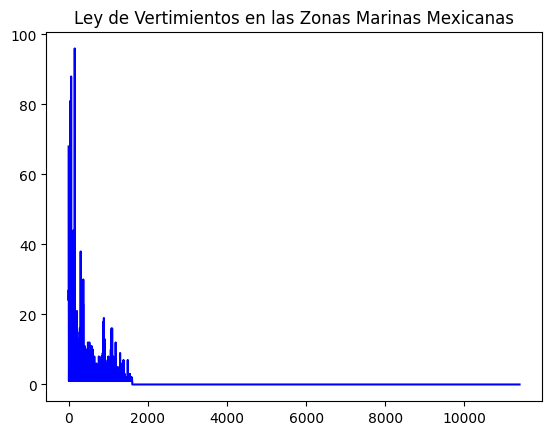

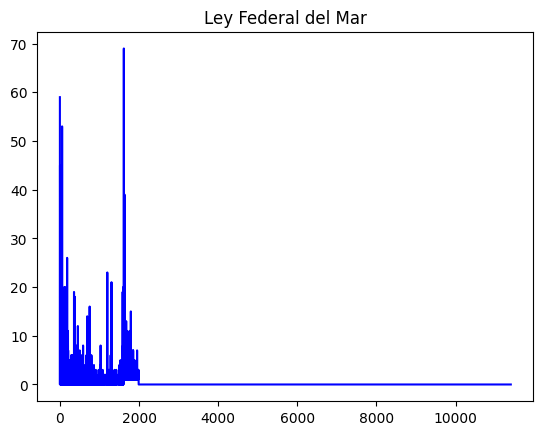

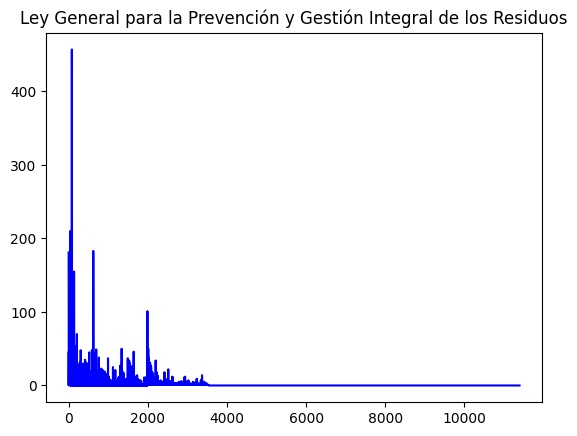

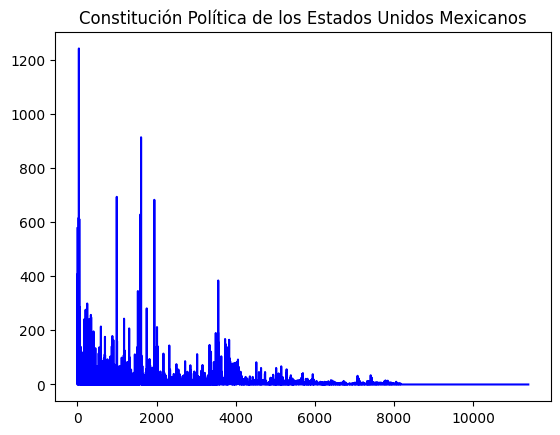

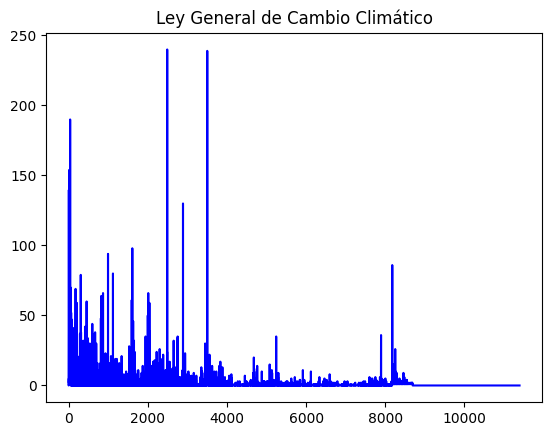

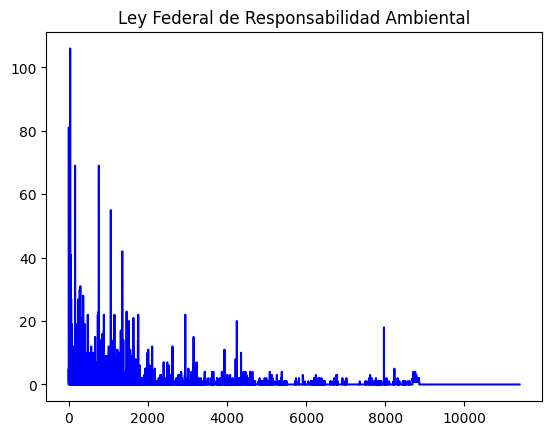

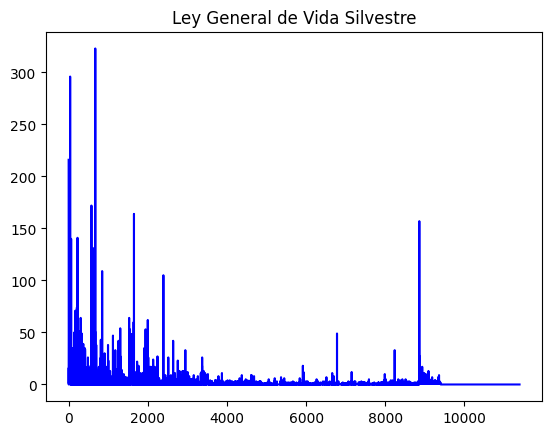

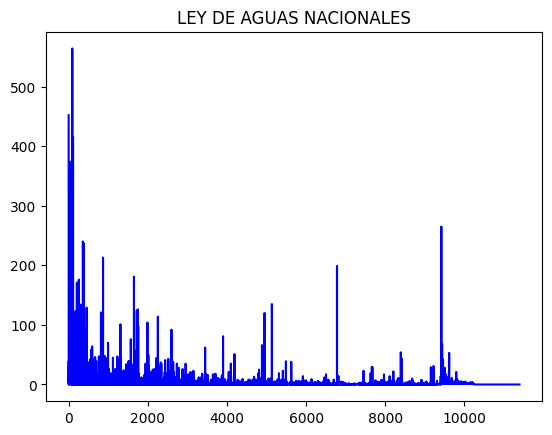

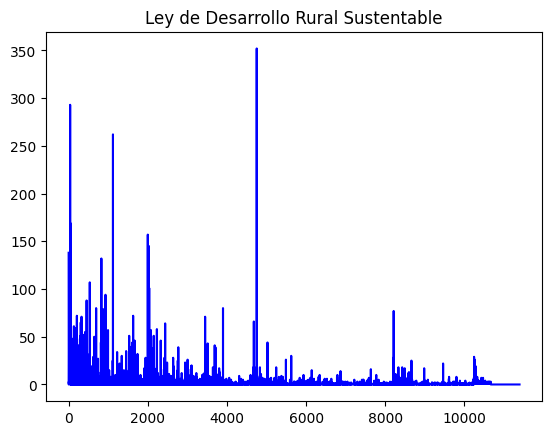

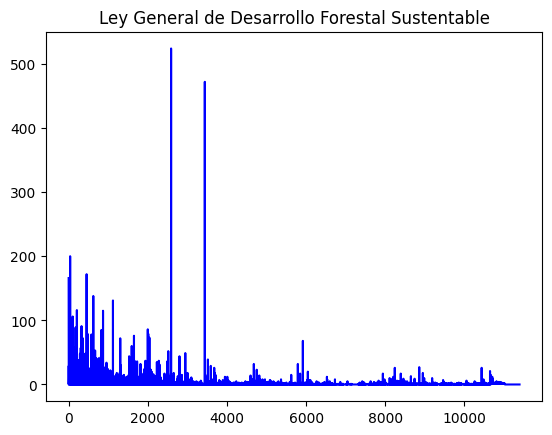

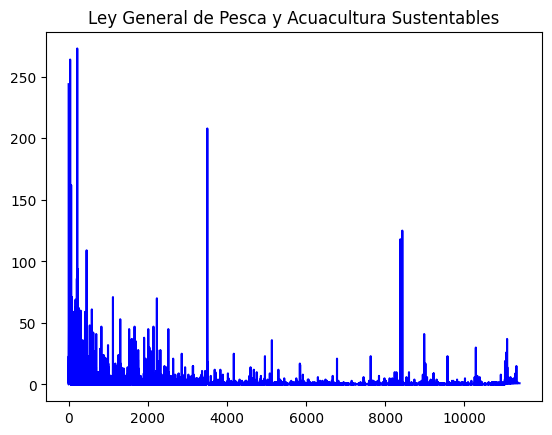

In [89]:
#Copy of global dictionary
dict_tf_per_document = dictionary.copy()

#Empty list to store individual document frequency results versus global dictionary
dict_freq_per_doc = []

for k in range(len(frequency_per_doc)):

  #Reset TF in current loop
  for token in dictionary:
    dict_tf_per_document[token] = 0

  #print(dict_tf_per_document.most_common(10))

  #Assign frequency from current token in global dictionary

  for token in frequency_per_doc[k]:
    dict_tf_per_document[token] = frequency_per_doc[k][token]

  #Plot current TF
  plt.plot(list(np.arange(len(dict_tf_per_document))), list(dict_tf_per_document.values()), color='blue')
  plt.title(df['Title'][k])
  plt.show()

  #print(dict_tf_per_document.most_common(10))

  #dict_freq_per_doc.append(dict_tf_per_document)
  #print(dict_freq_per_doc[k].most_common(10))
  #print("current k: "+str(k))

#for k in range(len(dict_freq_per_doc)):


#print(dict_freq_per_doc[0].most_common(10))
#print(dict_freq_per_doc[10].most_common(10))

#for k in range(len(dict_freq_per_doc)):
  #print("current k: "+str(k))
  #print(dict_freq_per_doc[k].most_common(10))



###References:

Kane, M. S. (2023, November 2). Corpus analysis with Spacy. Programming Historian. https://programminghistorian.org/en/lessons/corpus-analysis-with-spacy

Martinez-Seis, B., Pichardo-Lagunas, O., Koff, H., Equihua, M., Perez-Maqueo, O., & Hernández-Huerta, A. (2022, July 6). Unified, labeled, and semi-structured database of pre-processed Mexican laws. MDPI. https://www.mdpi.com/2306-5729/7/7/91

Panchal, A. (2023, July 8). Text summarization using TF-IDF. Medium. https://towardsdatascience.com/text-summarization-using-tf-idf-e64a0644ace3
